# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [3]:
!pip install xgboost

    100% |████████████████████████████████| 142.8MB 340kB/s eta 0:00:01  8% |██▋                             | 11.9MB 48.5MB/s eta 0:00:03    90% |████████████████████████████▉   | 128.9MB 58.0MB/s eta 0:00:01
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [18]:
!pip install auto_ml

pathos 0.2.5 has requirement dill>=0.3.1, but you'll have dill 0.2.9 which is incompatible.
multiprocess 0.70.9 has requirement dill>=0.3.1, but you'll have dill 0.2.9 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
!pip install imblearn

pathos 0.2.5 has requirement dill>=0.3.1, but you'll have dill 0.2.9 which is incompatible.
multiprocess 0.70.9 has requirement dill>=0.3.1, but you'll have dill 0.2.9 which is incompatible.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [19]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pickle

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from auto_ml import Predictor
from imblearn.combine import SMOTETomek
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [5]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
#Loading Missing Value Checkbook
missing_value_checkbook= pd.read_excel('Missing Value Checkbook.xlsx', sheet_name = 'Tabelle1')

### Data Exploration

In [7]:
# data shape
azdias.shape

(891221, 366)

In [8]:
# data info
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [9]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [15]:
missing_value_checkbook.shape

(1838, 4)

In [16]:
missing_value_checkbook.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
2,ALTER_HH,main age within the household,0,unknown / no main age detectable
3,ANREDE_KZ,gender,"-1, 0",unknown
4,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)


In [17]:
# droping NaN in Attribute
missing_value_checkbook = missing_value_checkbook[~missing_value_checkbook['Attribute'].isnull()]
# getting a list of the attributes elaborated on in the excel file
list_of_dias_attributes = list(missing_value_checkbook['Attribute'])

In [18]:
len(list_of_dias_attributes)

314

In [20]:
missing_value_checkbook = missing_value_checkbook.set_index('Attribute')

In [21]:
missing_value_checkbook = missing_value_checkbook.T

In [22]:
missing_value_checkbook.head()

Attribute,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,BIP_FLAG,...,SEMIO_VERT,SHOPPER_TYP,SOHO_FLAG,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,WACHSTUMSGEBIET_NB,W_KEIT_KIND_HH,ZABEOTYP
Description,best-ager typology,age classification through prename analysis,main age within the household,gender,number of households in the building,number of academic title holder in building,number of adult persons in the household,number of professional title holder in household,distance to next urban centre,business-flag indicating companies in the buil...,...,affinity indicating in what way the person is ...,shopping typology,small office/home office flag,flag whether this person holds an academic title,insurance typology,length of residence,residential-area,growing area (population growth in the last 5 ...,likelihood of a child present in this household,typification of energy consumers
Value,-1,"-1, 0",0,"-1, 0",…,…,…,…,-1,-1,...,"-1, 9",-1,-1,"-1, 0",-1,"-1, 0",-1,"-1, 0","-1, 0","-1, 9"
Meaning,unknown,unknown,unknown / no main age detectable,unknown,numeric value (typically coded from 1-10),numeric value (typically coded from 1-10),numeric value (typically coded from 1-3),numeric value (typically coded from 1-10),unknown,unknown,...,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1 Experimental Data Cleaning

In [23]:
# dropping any column that is in azdias but not explained in DIAS Attributes
azdias = azdias.filter(items=list_of_dias_attributes)
azdias.shape

(891221, 272)

In [24]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
0,-1,2,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,2,3,1,-1,NaN,-1,NaN,NaN,NaN,3
1,-1,1,0.0,2,11.0,0.0,2.0,0.0,6.0,8,...,5,6,1,3,0.0,2,9.0,4.0,3.0,5
2,-1,3,17.0,2,10.0,0.0,1.0,0.0,2.0,4,...,4,3,4,2,0.0,1,9.0,2.0,3.0,5
3,2,4,13.0,2,1.0,0.0,0.0,0.0,4.0,2,...,5,4,4,1,0.0,1,9.0,7.0,NaN,3
4,-1,3,20.0,1,3.0,0.0,4.0,0.0,2.0,6,...,6,2,7,2,0.0,2,9.0,3.0,2.0,4


In [25]:
remaining_features = list(azdias.columns)

In [26]:
missing_value_checkbook = missing_value_checkbook.filter(items=remaining_features)

In [27]:
missing_value_checkbook.to_csv('DIAS_Missing_Data_Codes.csv')

First we will look for collumns with unusual volume of NaNs, we will likely want to drop these as they could prove problematic for our kmeans clustering. Looking at the provided excel sheet DIAS Attributes 2017 we also know that -1 is used in some collumns to describe missing data as well so we will replace all instances with NaNs.

In [28]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
0,-1,2,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,...,2,3,1,-1,NaN,-1,NaN,NaN,NaN,3
1,-1,1,0.0,2,11.0,0.0,2.0,0.0,6.0,8,...,5,6,1,3,0.0,2,9.0,4.0,3.0,5
2,-1,3,17.0,2,10.0,0.0,1.0,0.0,2.0,4,...,4,3,4,2,0.0,1,9.0,2.0,3.0,5
3,2,4,13.0,2,1.0,0.0,0.0,0.0,4.0,2,...,5,4,4,1,0.0,1,9.0,7.0,NaN,3
4,-1,3,20.0,1,3.0,0.0,4.0,0.0,2.0,6,...,6,2,7,2,0.0,2,9.0,3.0,2.0,4


In [29]:
#standardizing encoding of missing values to be NaN
for att in missing_value_checkbook.columns:
    azdias.loc[azdias[att].isin(missing_value_checkbook[att]), att] = np.nan

In [30]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,...,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
0,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0
1,NaN,1.0,NaN,2.0,11.0,0.0,2.0,0.0,6.0,8,...,5.0,6.0,1.0,3.0,0.0,2.0,9.0,4.0,3.0,5.0
2,NaN,3.0,17.0,2.0,10.0,0.0,1.0,0.0,2.0,4,...,4.0,3.0,4.0,2.0,0.0,1.0,9.0,2.0,3.0,5.0
3,2.0,4.0,13.0,2.0,1.0,0.0,0.0,0.0,4.0,2,...,5.0,4.0,4.0,1.0,0.0,1.0,9.0,7.0,NaN,3.0
4,NaN,3.0,20.0,1.0,3.0,0.0,4.0,0.0,2.0,6,...,6.0,2.0,7.0,2.0,0.0,2.0,9.0,3.0,2.0,4.0


In [31]:
# assessing missing data in each column
col_nan = 100*azdias.isna().sum()/len(azdias)

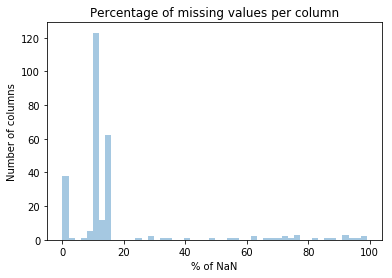

In [32]:
plt.figure()
sns.distplot(col_nan.values, kde=False)
plt.ylabel('Number of columns')
plt.xlabel('% of NaN')
plt.title('Percentage of missing values per column')
plt.show()

Collumns with more than 30% missing data seem the exception and could hurt our clustering. We will drop them. 

In [33]:
# defining colums to drop
col_nan_drop_threshold = col_nan[col_nan > 30]
high_nan_cols = list(col_nan_drop_threshold.index)
# checking columns to be romoved
len(high_nan_cols)
print(high_nan_cols)

['AGER_TYP', 'ALTER_HH', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'MOBI_REGIO', 'PLZ8_BAUMAX']


In [34]:
# dropping high NaN collumns
azdias.drop(high_nan_cols, axis = 1, inplace = True)
azdias.shape

(891221, 245)

We will also want to have a look at rows with unusually high NaNs and remove those as well. 

In [35]:
# assessing missing data in each row
row_nan = 100*azdias.isnull().sum(axis=1)/len(azdias.columns)

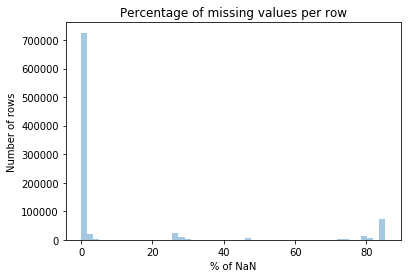

In [36]:
plt.figure()
sns.distplot(row_nan.values, kde=False)
plt.ylabel('Number of rows')
plt.xlabel('% of NaN')
plt.title('Percentage of missing values per row')
plt.show()

Dropping Rows with unusually high NaNs (>30%).

In [37]:
# defining rows to drop
row_nan_drop_threshold = row_nan[row_nan > 30]
high_nan_rows = list(row_nan_drop_threshold.index)
# checking number of rows to be romoved
len(high_nan_rows)

106314

In [38]:
# dropping high NaN rows
azdias.drop(high_nan_rows, axis = 0, inplace = True)
azdias.shape

(784907, 245)

In [39]:
# checking what features remain
pd.set_option('max_columns', 280)
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,CAMEO_DEUG_2015,CAMEO_DEU_2015,CJT_GESAMTTYP,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_DATUM,D19_KONSUMTYP,EWDICHTE,FINANZTYP,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_0_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_180,KBA13_KMH_0_140,KBA13_KMH_140_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_0_60,KBA13_KW_70,KBA13_KW_61_120,KBA13_KW_80,KBA13_KW_90,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,W_KEIT_KIND_HH,ZABEOTYP
1,1.0,2.0,11.0,0.0,2.0,0.0,6.0,8,8A,5.0,NaN,10.0,NaN,3.0,1.0,5.0,5.0,1.0,5.0,4.0,2.0,8.0,3.0,1996.0,10.0,0.0,3.0,6.0,8.0,3.0,4.0,1.0,4.0,0.0,0.0,0.0,0.0,2.0,NaN,5.0,1.0,5.0,1.0,4.0,2.0,4.0,1.0,5.0,5.0,2.0,2.0,0.0,4.0,1.0,5.0,4.0,2.0,1.0,2.0,1.0,2.0,1.0,3.0,4.0,2.0,1.0,2.0,4.0,3.0,3.0,2.0,2.0,0.0,0.0,1.0,3.0,0.0,0.0,4.0,1.0,2.0,2.0,2.0,1.0,3.0,3.0,0.0,1.0,1.0,5.0,5.0,1.0,0.0,2.0,3.0,2.0,3.0,4.0,963.0,4.0,2.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,0.0,0.0,4.0,2.0,1.0,2.0,2.0,5.0,3.0,3.0,0.0,5.0,2.0,3

In [12]:
preprocessed_features = list(azdias.columns)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
with open('preprocessed_features.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(preprocessed_features, filehandle)

In [60]:
cleaning_fuction_missing_value_cb = missing_value_checkbook.filter(items = preprocessed_features)
cleaning_fuction_missing_value_cb.to_csv('Missing Value Checkbook for the Cleaning Fuction.csv')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [50]:
#determining which variables represent non-sequential categorical data which require one-hot encoding.
needs_one_hot= ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'D19_KONSUMTYP',
                'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP', 
                'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 
                'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 
                'LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB', 
                'LP_STATUS_FEIN', 'LP_STATUS_GROB',
                'NATIONALITAET_KZ','PRAEGENDE_JUGENDJAHRE', 'REGIOTYP', 
                'RETOURTYP_BK_S', 'SHOPPER_TYP', 'ZABEOTYP']

In [51]:
#re-encoding OST_WEST_KZ as numeric variable
azdias['OST_WEST_KZ'] =  azdias['OST_WEST_KZ'].map({'W': 1, 'O': 2})

In [52]:
#encoding non-sequential categorical variables as one-hot
azdias_cleaned = pd.get_dummies(azdias, columns=needs_one_hot)

In [53]:
azdias_cleaned.shape

(784907, 473)

In [54]:
# saving cleaned data to csv
azdias_cleaned.to_csv('Cleaned_AZDIAS.csv')

### 1.2 Feature Selection and Data Cleaning

#### Defining the Cleaning Fuction
This cleaning fuction combines all steps from the experimental cleaning.

In [106]:
# reading in data for the cleaning fuction
with open('preprocessed_features.data', 'rb') as filehandle:
    # read the data as binary data stream
    preprocessed_features = pickle.load(filehandle)

mvc = pd.read_csv('Missing Value Checkbook for the Cleaning Fuction.csv', index_col = 0)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [107]:
# defining the data cleaning fuction
def clean_data(df, preprocessed_features = preprocessed_features, mvc = mvc, drop_col=True, drop_row=True):
    '''
    Inputs: Data Frame, list of features to keep, and missing value checkbook
    Output: Cleaned Data
    '''
    # applying filter based on preprocessed data dropping high NaN columns and features not explained in DIAS Attribute 2017
    df = df.filter(items = preprocessed_features)
    
    # consistently encode missing values as NaN
    for att in mvc.columns:
        df.loc[df[att].isin(mvc[att]), att] = np.nan
    
    # calculating NaN % in rows and dropping those above the threshold
    row_nan = df.isnull().sum(axis=1)/len(df.columns)
    row_nan_drop_threshold = row_nan[row_nan > 0.3]
    high_nan_rows = list(row_nan_drop_threshold.index)
    df = df.drop(high_nan_rows, axis = 0)
    
    # re-encoding OST_WEST_KZ as numeric variable
    df['OST_WEST_KZ'] =  df['OST_WEST_KZ'].map({'W': 1, 'O': 2})
    
    needs_one_hot= ['CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'CJT_GESAMTTYP', 'D19_KONSUMTYP',
                    'FINANZTYP', 'GEBAEUDETYP', 'GFK_URLAUBERTYP', 
                    'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 
                    'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 
                    'LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB', 
                    'LP_STATUS_FEIN', 'LP_STATUS_GROB',
                    'NATIONALITAET_KZ','PRAEGENDE_JUGENDJAHRE', 'REGIOTYP', 
                    'RETOURTYP_BK_S', 'SHOPPER_TYP', 'ZABEOTYP']
    # re-encoding non-sequential categorical variables as one-hot
    df = pd.get_dummies(df, columns=needs_one_hot)
    return df

We will now clean the customer data and save it to csv so we do not have to run through the time consuming cleaning process again.

In [108]:
customers_cleaned = clean_data(customers)
customers_cleaned.shape
customers_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_DATUM,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_0_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_180,KBA13_KMH_0_140,KBA13_KMH_140_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,...,KBA05_MAXHERST_4.0,KBA05_MAXHERST_5.0,KBA05_MAXHERST_9.0,KBA05_MODTEMP_1.0,KBA05_MODTEMP_2.0,KBA05_MODTEMP_3.0,KBA05_MODTEMP_4.0,KBA05_MODTEMP_5.0,KBA05_MODTEMP_6.0,LP_FAMILIE_FEIN_0.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_0.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_LEBENSPHASE_FEIN_0.0,LP_LEBENSPHASE_FEIN_1.0,LP_LEBENSPHASE_FEIN_2.0,LP_LEBENSPHASE_FEIN_3.0,LP_LEBENSPHASE_FEIN_4.0,LP_LEBENSPHASE_FEIN_5.0,LP_LEBENSPHASE_FEIN_6.0,LP_LEBENSPHASE_FEIN_7.0,LP_LEBENSPHASE_FEIN_8.0,LP_LEBENSPHASE_FEIN_9.0,LP_LEBENSPHASE_FEIN_10.0,LP_LEBENSPHASE_FEIN_11.0,LP_LEBENSPHASE_FEIN_12.0,LP_LEBENSPHASE_FEIN_13.0,LP_LEBENSPHASE_FEIN_14.0,LP_LEBENSPHASE_FEIN_15.0,LP_LEBENSPHASE_FEIN_16.0,LP_LEBENSPHASE_FEIN_17.0,LP_LEBENSPHASE_FEIN_18.0,LP_LEBENSPHASE_FEIN_19.0,LP_LEBENSPHASE_FEIN_20.0,LP_LEBENSPHASE_FEIN_21.0,LP_LEBENSPHASE_FEIN_22.0,LP_LEBENSPHASE_FEIN_23.0,LP_LEBENSPHASE_FEIN_24.0,LP_LEBENSPHASE_FEIN_25.0,LP_LEBENSPHASE_FEIN_26.0,LP_LEBENSPHASE_FEIN_27.0,LP_LEBENSPHASE_FEIN_28.0,LP_LEBENSPHASE_FEIN_29.0,LP_LEBENSPHASE_FEIN_30.0,LP_LEBENSPHASE_FEIN_31.0,LP_LEBENSPHASE_FEIN_32.0,LP_LEBENSPHASE_FEIN_33.0,LP_LEBENSPHASE_FEIN_34.0,LP_LEBENSPHASE_FEIN_35.0,LP_LEBENSPHASE_FEIN_36.0,LP_LEBENSPHASE_FEIN_37.0,LP_LEBENSPHASE_FEIN_38.0,LP_LEBENSPHASE_FEIN_39.0,LP_LEBENSPHASE_FEIN_40.0,LP_LEBENSPHASE_GROB_0.0,LP_LEBENSPHASE_GROB_1.0,LP_LEBENSPHASE_GROB_2.0,LP_LEBENSPHASE_GROB_3.0,LP_LEBENSPHASE_GROB_4.0,LP_LEBENSPHASE_GROB_5.0,LP_LEBENSPHASE_GROB_6.0,LP_LEBENSPHASE_GROB_7.0,LP_LEBENSPHASE_GROB_8.0,LP_LEBENSPHASE_GROB_9.0,LP_LEBENSPHASE_GROB_10.0,LP_LEBENSPHASE_GROB_11.0,LP_LEBENSPHASE_GROB_12.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_

In [109]:
customers_cleaned.to_csv('Cleaned_Customers.csv')

### 1.3 Scaling and Dimensionality Reduction

In [56]:
#reading in the cleaned data
azdias_cleaned = pd.read_csv('Cleaned_AZDIAS.csv')
customers_cleaned = pd.read_csv('Cleaned_Customers.csv')

In [3]:
# selecting imputer to replace missing values
Imp = SimpleImputer(missing_values=np.nan, strategy='median')
azdias_imp = pd.DataFrame(Imp.fit_transform(azdias_cleaned.values),
                          columns=azdias_cleaned.columns)
customers_imp = pd.DataFrame(Imp.transform(customers_cleaned.values),
                          columns=customers_cleaned.columns)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [5]:
# appling feature scaling to the general population demographics and customer data

scaler = RobustScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_imp.values),
                          columns=azdias_imp.columns)
customers_scaled = pd.DataFrame(scaler.transform(customers_imp.values),
                          columns=customers_imp.columns)

In [6]:
# cleaning up variables
del azdias_imp
del customers_imp

In [7]:
# performing principle components analysis on the scaled data
pca = PCA().fit(azdias_scaled)

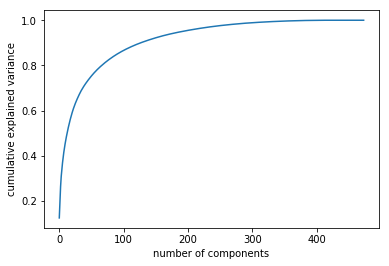

In [8]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

It appears that 200 components appear to explain well over 90% of the variance in our scaled data.

In [9]:
#re-fitting PCA with selected number of components. 
pca = PCA(n_components=200)
azdias_pca = pca.fit_transform(azdias_scaled)
customers_pca = pca.transform(customers_scaled)

### 1.4 K-means Custering

In [12]:
# defining fuction to compute the average intra-cluster distance in kmeans clustered data


def get_kmeans_score(data, c):
    '''
    returns the Sum of Squared Error as a measure of distance from data points to cluster centers
    INPUT:
        data - the dataset you want to fit kmeans to
        c - the number of selected centers (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    # instantiating kmeans
    kmeans = MiniBatchKMeans(n_clusters=c)

    # fitting the model to your data using the fit method
    model = kmeans.fit(data)
    
    # obtaing SSE score related to the fit model
    score = np.abs(model.score(data))
    
    return score

We will iterate over a selection of plausible numbers of clusters and get SSE scores for each. This will allow us to select the number of clusters we actually want to use for our final segmentation. The goal is to select clusters so that all of our target market segment, people similar to our existing customer base, fall into a single cluster, or are at least clearly sperated from the rest of the population.

In [36]:
# initiating an empty list of scores and defining a range of clusters to be investigated
score_list = []
clusters = np.arange(2, 20, 1)

# iterating over a range of clusters from 2 to 10
for c in clusters: 
    score_list.append(get_kmeans_score(azdias_pca, c))

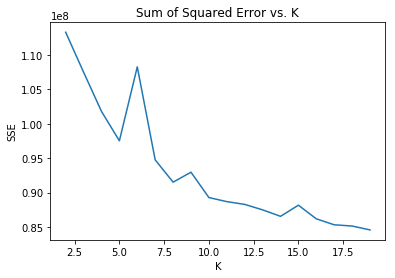

In [37]:
# investigating the change in intra-cluster distance across selected variation of clusters

plt.figure() 
plt.plot(clusters, score_list);
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Sum of Squared Error vs. K')
plt.show()

Selecting 5, 8 or 14 clusters seem to be solid choices for each an 'elbow' is visible in the score graph. Past 14 SSE reduction appears to becomes marginal. We will check all three indicated clusterings.

In [38]:
#fitting the k-means model with selected number of clusters
kmeans = KMeans(n_clusters=5)
azdias_labels = kmeans.fit_predict(azdias_pca)

In [39]:
cluster_count_azdias = pd.Series(azdias_labels).value_counts()

clusters_azdias = pd.DataFrame({'cluster': cluster_count_azdias.index,
                           '% of data': 100*cluster_count_azdias.values/len(azdias_labels)})
clusters_azdias['data'] = 'general population'

# printing clusters_azdias
clusters_azdias

,cluster,% of data,data
0,1,35.425216,general population
1,4,29.664279,general population
2,3,27.460706,general population
3,0,5.660671,general population
4,2,1.789129,general population


Generating labels for the existing customers using the K-means model fit to the general population data.

In [40]:
customers_labels = kmeans.predict(customers_pca)

In [41]:
cluster_count_customers = pd.Series(customers_labels).value_counts()

clusters_customers = pd.DataFrame({'cluster': cluster_count_customers.index,
                           '% of data': 100*cluster_count_customers.values/len(customers_labels)})
clusters_customers['data'] = 'customers'

# printing clusters_customers
clusters_customers

,cluster,% of data,data
0,1,41.747248,customers
1,3,41.422311,customers
2,4,11.303666,customers
3,0,4.886878,customers
4,2,0.639897,customers


Comparing general population and customer clustering.

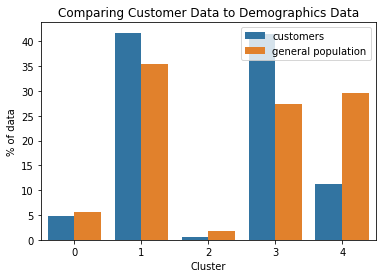

In [42]:
plt.figure()
sns.barplot(x="cluster", y="% of data", hue="data",
            data=pd.concat([clusters_customers, clusters_azdias]))
plt.xlabel('Cluster')
plt.ylabel('% of data')
plt.title('Comparing Customer Data to Demographics Data')
plt.legend()
plt.show()

### Findings 5 clusters:
We can see that customers are clearly over represented compared to the general population in clusters 0 and 6, and under represented in clusters 3 and 1 colectively accounting for just over 83% of the customer data, and encompasing just under 63% of the general population.

In [43]:
#fitting the k-means model with selected number of clusters
kmeans2 = KMeans(n_clusters=8)
azdias_labels2 = kmeans2.fit_predict(azdias_pca)

In [44]:
cluster_count_azdias2 = pd.Series(azdias_labels2).value_counts()

clusters_azdias2 = pd.DataFrame({'cluster': cluster_count_azdias2.index,
                           '% of data': 100*cluster_count_azdias2.values/len(azdias_labels2)})
clusters_azdias2['data'] = 'general population'

# printing clusters_azdias
clusters_azdias2

,cluster,% of data,data
0,2,25.429000,general population
1,5,19.319359,general population
2,4,18.525762,general population
3,6,12.251643,general population
4,3,12.245272,general population
5,1,5.282537,general population
6,0,5.157299,general population
7,7,1.789129,general population


In [45]:
customers_labels2 = kmeans2.predict(customers_pca)

In [46]:
cluster_count_customers2 = pd.Series(customers_labels2).value_counts()

clusters_customers2 = pd.DataFrame({'cluster': cluster_count_customers2.index,
                           '% of data': 100*cluster_count_customers2.values/len(customers_labels2)})
clusters_customers2['data'] = 'customers'

# printing clusters_customers
clusters_customers2

,cluster,% of data,data
0,2,37.171055,customers
1,4,32.564221,customers
2,5,11.246660,customers
3,6,5.644351,customers
4,1,4.606121,customers
5,0,4.403036,customers
6,3,3.724659,customers
7,7,0.639897,customers


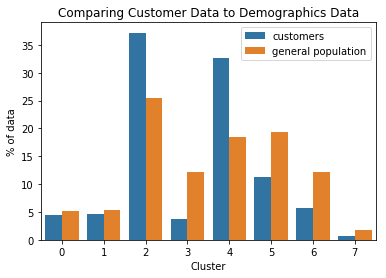

In [47]:
plt.figure()
sns.barplot(x="cluster", y="% of data", hue="data",
            data=pd.concat([clusters_customers2, clusters_azdias2]))
plt.xlabel('Cluster')
plt.ylabel('% of data')
plt.title('Comparing Customer Data to Demographics Data')
plt.legend()
plt.show()

### Findings 8 Clusters:
Customer data is over represented in clusters 2 and 4, together accounting for over 69% of the customers. These clusters account for just under 44% of the general population data.

In [48]:
#fitting the k-means model with selected number of clusters
kmeans3 = KMeans(n_clusters=14)
azdias_labels3 = kmeans3.fit_predict(azdias_pca)

In [49]:
cluster_count_azdias3 = pd.Series(azdias_labels3).value_counts()

clusters_azdias3 = pd.DataFrame({'cluster': cluster_count_azdias3.index,
                           '% of data': 100*cluster_count_azdias3.values/len(azdias_labels3)})
clusters_azdias3['data'] = 'general population'

# printing clusters_azdias
clusters_azdias3

,cluster,% of data,data
0,12,10.404417,general population
1,4,10.261470,general population
2,5,10.122346,general population
3,6,9.919137,general population
4,11,9.796575,general population
5,1,8.210145,general population
6,13,7.669571,general population
7,9,7.316026,general population
8,8,7.096510,general population
9,0,6.325081,general population


In [50]:
customers_labels3 = kmeans3.predict(customers_pca)

In [51]:
cluster_count_customers3 = pd.Series(customers_labels3).value_counts()

clusters_customers3 = pd.DataFrame({'cluster': cluster_count_customers3.index,
                           '% of data': 100*cluster_count_customers3.values/len(customers_labels3)})
clusters_customers3['data'] = 'customers'

# printing cluster_customers
clusters_customers3

,cluster,% of data,data
0,4,23.743186,customers
1,6,17.033527,customers
2,13,15.624755,customers
3,11,12.322657,customers
4,5,5.976414,customers
5,12,4.920369,customers
6,7,4.462180,customers
7,10,4.346029,customers
8,1,4.306125,customers
9,0,2.310186,customers


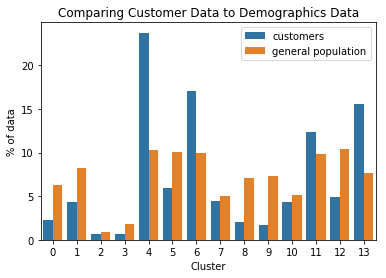

In [52]:
plt.figure()
sns.barplot(x="cluster", y="% of data", hue="data",
            data=pd.concat([clusters_customers3, clusters_azdias3]))
plt.xlabel('Cluster')
plt.ylabel('% of data')
plt.title('Comparing Customer Data to Demographics Data')
plt.legend()
plt.show()

### Findings 14 Clusters:
78% of customer data is captured by clusters 4,6,11 and 13, which represents about 38% of the general population. Since we are trying to find a population segment to target this selection seems to make the most sense. We could remove cluster 11 as it is the one with the least customer overrepresentation, if we want to narrow our target window to below 30% of Germanies general population.

In [57]:
# selecting target clusters for analysis and reversing pca and scaling
target_clusters = [4, 6, 11, 13]
target_pca = pca.inverse_transform(azdias_pca[np.isin(azdias_labels3, target_clusters)])
azdias_target = scaler.inverse_transform(target_pca).round()

In [58]:
azdias_target = pd.DataFrame(azdias_target, columns=azdias_cleaned.columns)

In [59]:
azdias_target.head()

,Unnamed: 0,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_DATUM,...,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0
0,-1054.0,3.0,2.0,1.0,-0.0,-0.0,-0.0,4.0,-0.0,10.0,...,-0.0,1.0,-0.0,0.0,0.0,0.0,1.0,-0.0,0.0,-0.0
1,-3568.0,1.0,2.0,5.0,0.0,1.0,-0.0,6.0,0.0,4.0,...,1.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,1.0,-0.0,0.0
2,-1907.0,2.0,1.0,6.0,0.0,1.0,0.0,2.0,-0.0,10.0,...,1.0,-0.0,-0.0,0.0,1.0,-0.0,0.0,-0.0,-0.0,0.0
3,-1844.0,3.0,1.0,3.0,0.0,1.0,0.0,4.0,-0.0,10.0,...,-0.0,0.0,-0.0,1.0,0.0,0.0,-0.0,0.0,0.0,0.0
4,969.0,3.0,2.0,9.0,0.0,1.0,0.0,5.0,-0.0,5.0,...,-0.0,0.0,0.0,1.0,-0.0,0.0,-0.0,1.0,0.0,0.0


In [62]:
azdias_target = azdias_target.drop('Unnamed: 0', axis=1)

In [64]:
pd.set_option('max_columns', 280)
azdias_target.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_DATUM,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_0_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_180,KBA13_KMH_0_140,KBA13_KMH_140_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,...,KBA05_MAXHERST_3.0,KBA05_MAXHERST_4.0,KBA05_MAXHERST_5.0,KBA05_MAXHERST_9.0,KBA05_MODTEMP_1.0,KBA05_MODTEMP_2.0,KBA05_MODTEMP_3.0,KBA05_MODTEMP_4.0,KBA05_MODTEMP_5.0,KBA05_MODTEMP_6.0,LP_FAMILIE_FEIN_0.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_0.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_LEBENSPHASE_FEIN_0.0,LP_LEBENSPHASE_FEIN_1.0,LP_LEBENSPHASE_FEIN_2.0,LP_LEBENSPHASE_FEIN_3.0,LP_LEBENSPHASE_FEIN_4.0,LP_LEBENSPHASE_FEIN_5.0,LP_LEBENSPHASE_FEIN_6.0,LP_LEBENSPHASE_FEIN_7.0,LP_LEBENSPHASE_FEIN_8.0,LP_LEBENSPHASE_FEIN_9.0,LP_LEBENSPHASE_FEIN_10.0,LP_LEBENSPHASE_FEIN_11.0,LP_LEBENSPHASE_FEIN_12.0,LP_LEBENSPHASE_FEIN_13.0,LP_LEBENSPHASE_FEIN_14.0,LP_LEBENSPHASE_FEIN_15.0,LP_LEBENSPHASE_FEIN_16.0,LP_LEBENSPHASE_FEIN_17.0,LP_LEBENSPHASE_FEIN_18.0,LP_LEBENSPHASE_FEIN_19.0,LP_LEBENSPHASE_FEIN_20.0,LP_LEBENSPHASE_FEIN_21.0,LP_LEBENSPHASE_FEIN_22.0,LP_LEBENSPHASE_FEIN_23.0,LP_LEBENSPHASE_FEIN_24.0,LP_LEBENSPHASE_FEIN_25.0,LP_LEBENSPHASE_FEIN_26.0,LP_LEBENSPHASE_FEIN_27.0,LP_LEBENSPHASE_FEIN_28.0,LP_LEBENSPHASE_FEIN_29.0,LP_LEBENSPHASE_FEIN_30.0,LP_LEBENSPHASE_FEIN_31.0,LP_LEBENSPHASE_FEIN_32.0,LP_LEBENSPHASE_FEIN_33.0,LP_LEBENSPHASE_FEIN_34.0,LP_LEBENSPHASE_FEIN_35.0,LP_LEBENSPHASE_FEIN_36.0,LP_LEBENSPHASE_FEIN_37.0,LP_LEBENSPHASE_FEIN_38.0,LP_LEBENSPHASE_FEIN_39.0,LP_LEBENSPHASE_FEIN_40.0,LP_LEBENSPHASE_GROB_0.0,LP_LEBENSPHASE_GROB_1.0,LP_LEBENSPHASE_GROB_2.0,LP_LEBENSPHASE_GROB_3.0,LP_LEBENSPHASE_GROB_4.0,LP_LEBENSPHASE_GROB_5.0,LP_LEBENSPHASE_GROB_6.0,LP_LEBENSPHASE_GROB_7.0,LP_LEBENSPHASE_GROB_8.0,LP_LEBENSPHASE_GROB_9.0,LP_LEBENSPHASE_GROB_10.0,LP_LEBENSPHASE_GROB_11.0,LP_LEBENSPHASE_GROB_12.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_

In [65]:
azdias_target.to_csv('AZDIAS Target Segment.csv')

### Analysis
Obviously we can not talk about each of the 473 columns of our data but we can take a look at some of the mean values to get a rough idea of what the target customers for that German mail order company look like. A mean of 2.97 with a standard deviation of 0.967 in the 'ALTERSKATEGORIE_GROB' column which translates to rough age category means that we are looking at a target audience in their 40ies. ANZ_PERSONEN tells us that we are looking on average at 2 person households. BALLRAUM tells us that we are looking at a target audience that lives 30-50 km away from the nearest urban center. The HH_EINKOMMEN_SCORE mean of 3.5 tells us that the target segment is middle to high income.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
# appending RESPONSE to list of dias attributes filter so the column is kept when the cleaning fuction is applied. 
preprocessed_features.append('RESPONSE')

In [ ]:
# cleaning training data
mailout_train_cleaned = clean_data(mailout_train)

In [ ]:
mailout_train_cleaned.head()

In [ ]:
# saving cleaned data to csv
mailout_train_cleaned.to_csv('Mailout_Train_Cleaned.csv')

In [70]:
mailout_train_cleaned = pd.read_csv('Mailout_Train_Cleaned.csv', index_col = 0)

In [71]:
mailout_train_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_DATUM,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_0_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_180,KBA13_KMH_0_140,KBA13_KMH_140_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,...,KBA05_MAXHERST_4.0,KBA05_MAXHERST_5.0,KBA05_MAXHERST_9.0,KBA05_MODTEMP_1.0,KBA05_MODTEMP_2.0,KBA05_MODTEMP_3.0,KBA05_MODTEMP_4.0,KBA05_MODTEMP_5.0,KBA05_MODTEMP_6.0,LP_FAMILIE_FEIN_0.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_0.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_LEBENSPHASE_FEIN_0.0,LP_LEBENSPHASE_FEIN_1.0,LP_LEBENSPHASE_FEIN_2.0,LP_LEBENSPHASE_FEIN_3.0,LP_LEBENSPHASE_FEIN_4.0,LP_LEBENSPHASE_FEIN_5.0,LP_LEBENSPHASE_FEIN_6.0,LP_LEBENSPHASE_FEIN_7.0,LP_LEBENSPHASE_FEIN_8.0,LP_LEBENSPHASE_FEIN_9.0,LP_LEBENSPHASE_FEIN_10.0,LP_LEBENSPHASE_FEIN_11.0,LP_LEBENSPHASE_FEIN_12.0,LP_LEBENSPHASE_FEIN_13.0,LP_LEBENSPHASE_FEIN_14.0,LP_LEBENSPHASE_FEIN_15.0,LP_LEBENSPHASE_FEIN_16.0,LP_LEBENSPHASE_FEIN_17.0,LP_LEBENSPHASE_FEIN_18.0,LP_LEBENSPHASE_FEIN_19.0,LP_LEBENSPHASE_FEIN_20.0,LP_LEBENSPHASE_FEIN_21.0,LP_LEBENSPHASE_FEIN_22.0,LP_LEBENSPHASE_FEIN_23.0,LP_LEBENSPHASE_FEIN_24.0,LP_LEBENSPHASE_FEIN_25.0,LP_LEBENSPHASE_FEIN_26.0,LP_LEBENSPHASE_FEIN_27.0,LP_LEBENSPHASE_FEIN_28.0,LP_LEBENSPHASE_FEIN_29.0,LP_LEBENSPHASE_FEIN_30.0,LP_LEBENSPHASE_FEIN_31.0,LP_LEBENSPHASE_FEIN_32.0,LP_LEBENSPHASE_FEIN_33.0,LP_LEBENSPHASE_FEIN_34.0,LP_LEBENSPHASE_FEIN_35.0,LP_LEBENSPHASE_FEIN_36.0,LP_LEBENSPHASE_FEIN_37.0,LP_LEBENSPHASE_FEIN_38.0,LP_LEBENSPHASE_FEIN_39.0,LP_LEBENSPHASE_FEIN_40.0,LP_LEBENSPHASE_GROB_0.0,LP_LEBENSPHASE_GROB_1.0,LP_LEBENSPHASE_GROB_2.0,LP_LEBENSPHASE_GROB_3.0,LP_LEBENSPHASE_GROB_4.0,LP_LEBENSPHASE_GROB_5.0,LP_LEBENSPHASE_GROB_6.0,LP_LEBENSPHASE_GROB_7.0,LP_LEBENSPHASE_GROB_8.0,LP_LEBENSPHASE_GROB_9.0,LP_LEBENSPHASE_GROB_10.0,LP_LEBENSPHASE_GROB_11.0,LP_LEBENSPHASE_GROB_12.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_

In [72]:
# moving lable column to the front
mailout_train_cleaned = mailout_train_cleaned[['RESPONSE'] + [ col for col in mailout_train_cleaned.columns if col != 'RESPONSE' ]]

In [73]:
mailout_train_cleaned.head()

,RESPONSE,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_DATUM,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GEBURTSJAHR,GREEN_AVANTGARDE,HEALTH_TYP,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_0_1400,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_180,KBA13_KMH_0_140,KBA13_KMH_140_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,...,KBA05_MAXHERST_4.0,KBA05_MAXHERST_5.0,KBA05_MAXHERST_9.0,KBA05_MODTEMP_1.0,KBA05_MODTEMP_2.0,KBA05_MODTEMP_3.0,KBA05_MODTEMP_4.0,KBA05_MODTEMP_5.0,KBA05_MODTEMP_6.0,LP_FAMILIE_FEIN_0.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_0.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_LEBENSPHASE_FEIN_0.0,LP_LEBENSPHASE_FEIN_1.0,LP_LEBENSPHASE_FEIN_2.0,LP_LEBENSPHASE_FEIN_3.0,LP_LEBENSPHASE_FEIN_4.0,LP_LEBENSPHASE_FEIN_5.0,LP_LEBENSPHASE_FEIN_6.0,LP_LEBENSPHASE_FEIN_7.0,LP_LEBENSPHASE_FEIN_8.0,LP_LEBENSPHASE_FEIN_9.0,LP_LEBENSPHASE_FEIN_10.0,LP_LEBENSPHASE_FEIN_11.0,LP_LEBENSPHASE_FEIN_12.0,LP_LEBENSPHASE_FEIN_13.0,LP_LEBENSPHASE_FEIN_14.0,LP_LEBENSPHASE_FEIN_15.0,LP_LEBENSPHASE_FEIN_16.0,LP_LEBENSPHASE_FEIN_17.0,LP_LEBENSPHASE_FEIN_18.0,LP_LEBENSPHASE_FEIN_19.0,LP_LEBENSPHASE_FEIN_20.0,LP_LEBENSPHASE_FEIN_21.0,LP_LEBENSPHASE_FEIN_22.0,LP_LEBENSPHASE_FEIN_23.0,LP_LEBENSPHASE_FEIN_24.0,LP_LEBENSPHASE_FEIN_25.0,LP_LEBENSPHASE_FEIN_26.0,LP_LEBENSPHASE_FEIN_27.0,LP_LEBENSPHASE_FEIN_28.0,LP_LEBENSPHASE_FEIN_29.0,LP_LEBENSPHASE_FEIN_30.0,LP_LEBENSPHASE_FEIN_31.0,LP_LEBENSPHASE_FEIN_32.0,LP_LEBENSPHASE_FEIN_33.0,LP_LEBENSPHASE_FEIN_34.0,LP_LEBENSPHASE_FEIN_35.0,LP_LEBENSPHASE_FEIN_36.0,LP_LEBENSPHASE_FEIN_37.0,LP_LEBENSPHASE_FEIN_38.0,LP_LEBENSPHASE_FEIN_39.0,LP_LEBENSPHASE_FEIN_40.0,LP_LEBENSPHASE_GROB_0.0,LP_LEBENSPHASE_GROB_1.0,LP_LEBENSPHASE_GROB_2.0,LP_LEBENSPHASE_GROB_3.0,LP_LEBENSPHASE_GROB_4.0,LP_LEBENSPHASE_GROB_5.0,LP_LEBENSPHASE_GROB_6.0,LP_LEBENSPHASE_GROB_7.0,LP_LEBENSPHASE_GROB_8.0,LP_LEBENSPHASE_GROB_9.0,LP_LEBENSPHASE_GROB_10.0,LP_LEBENSPHASE_GROB_11.0,LP_LEBENSPHASE_GROB_12.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP

In [74]:
# checking for data imbalance
mailout_train_cleaned.RESPONSE.value_counts(dropna=False)

0    34558
1      435
Name: RESPONSE, dtype: int64

Our data appears to be highly imbalanced. Only 435 positive responses were recieved out of over 35000 attempts.

In [76]:
#saving data to csv with Response as the first column
mailout_train_cleaned.to_csv('mailout_train_xgb.csv', index= False)

In [8]:
mailout_train_xgb = pd.read_csv('mailout_train_xgb.csv')

In [23]:
mailout_train_xgb.head()

,RESPONSE,ALTERSKATEGORIE_GROB,ANREDE_KZ,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,BALLRAUM,D19_BANKEN_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_DATUM,...,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1.0,ZABEOTYP_2.0,ZABEOTYP_3.0,ZABEOTYP_4.0,ZABEOTYP_5.0,ZABEOTYP_6.0
0,0,4.0,2.0,15.0,0.0,1.0,0.0,5.0,0.0,9.0,...,0,0,0,1,0,0,1,0,0,0
1,0,3.0,2.0,1.0,0.0,2.0,0.0,5.0,0.0,8.0,...,0,0,1,0,1,0,0,0,0,0
2,0,4.0,1.0,0.0,NaN,0.0,0.0,1.0,0.0,7.0,...,0,0,0,1,0,0,1,0,0,0
3,0,4.0,2.0,4.0,0.0,2.0,0.0,2.0,0.0,10.0,...,0,1,0,0,0,0,1,0,0,0
4,0,3.0,1.0,53.0,0.0,1.0,0.0,4.0,0.0,10.0,...,0,1,0,0,0,0,1,0,0,0


In [9]:
# splitting training data to get a validation or development set
dtrain, dtest = train_test_split(mailout_train_xgb, test_size=0.15)

In [27]:
dtrain.shape

(29744, 474)

In [28]:
dtest.shape

(5249, 474)

In [29]:
# splitting data into lables and features
labels_train = dtrain['RESPONSE']
data_train = dtrain.drop('RESPONSE', axis=1)
labels_test = dtest['RESPONSE']
data_test = dtest.drop('RESPONSE', axis=1)

In [30]:
# imputing missing values
Imp = SimpleImputer(missing_values=np.nan, strategy='median')
data_train_imp = pd.DataFrame(Imp.fit_transform(data_train.values),
                          columns=data_train.columns)
data_test_imp = pd.DataFrame(Imp.transform(data_test.values),
                          columns=data_test.columns)

In [31]:
# scaling the data
scaler = RobustScaler()
data_train_scaled = pd.DataFrame(scaler.fit_transform(data_train_imp.values),
                          columns=data_train_imp.columns)
data_test_scaled = pd.DataFrame(scaler.transform(data_test_imp.values),
                          columns=data_test_imp.columns)

In [32]:
training_set = xgb.DMatrix(data_train_scaled, label=labels_train)
validation_set = xgb.DMatrix(data_test_scaled, label=labels_test)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


We can see that without hyperparameter tuning XGBoost overfits our training data.

In [16]:
# defining AutoML model
column_descriptions = {'RESPONSE': 'output'}
automlmodel = Predictor(type_of_estimator='classifier', column_descriptions=column_descriptions)

In [11]:
models_names = ['AdaBoostClassifier', 'ExtraTreesClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier', 'XGBClassifier']

In [20]:
automlmodel.train(dtrain, model_names = 'XGBClassifier' , optimize_final_model=True)

Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.10
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


Running basic data cleaning
Fitting DataFrameVectorizer
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}


TypeError: __init__() got an unexpected keyword argument 'fit_params'

In [67]:
test_score = automlmodel.score(dtest, dtest.RESPONSE)

Here is our brier-score-loss, which is the default value we optimized for while training, and is the value returned from .score() unless you requested a custom scoring metric
It is a measure of how close the PROBABILITY predictions are.
0.0104

Here is the trained estimator's overall accuracy (when it predicts a label, how frequently is that the correct label?)
99.0%

Here is a confusion matrix showing predictions vs. actuals by label:
Predicted >     0   All
v Actual v             
0            5194  5194
1              55    55
All          5249  5249

Here is predictive value by class:
Class:  0 = 0.989521813678796
+--------------------+-----------------------------------+--------------------------------+
| Bucket Edges       |   Predicted Probability Of Bucket |   Actual Probability of Bucket |
|--------------------+-----------------------------------+--------------------------------|
| (0.00773, 0.00929] |                            0.0093 |                         0.0024 |
| (0.0

The AutoML result is disappointing as well. 99% accuracy is achived by essentially giving everything the dominant label '0'. Obviously we will have to adress class imbalance for our model to make at least some positive predictions.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
# cleaning test data
mailout_test_cleaned = clean_data(mailout_test)

In [ ]:
mailout_test_cleaned.head()

In [ ]:
# saving cleaned data to csv
mailout_test_cleaned.to_csv('Mailout_Test_Cleaned.csv')